In [1]:
import pandas as pd
import numpy as np
from google.colab import drive

In [2]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
weather = pd.read_csv('/content/drive/MyDrive/논문/solar_data 전처리/weather_in_Antwerp.txt', ';')
power_info = pd.read_csv('/content/drive/MyDrive/논문/solar_data 전처리/PV_Elec_Gas2.csv')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
# weather - 2012.01.01 ~ 2019.12.30 시간별 온도, 날씨, 풍속, 습도, 대기압, 가시거리
# power - 2011.10.26 ~ 2019.11.20 cum_power - 누적 태양광 발전량, 집의 일일 전력 소비량, 집의 일일 가스 소비량(난방에만 사용)

In [4]:
weather.shape, power_info.shape

((133669, 11), (2948, 4))

In [5]:
display(weather.head())
display(power_info.head())

,Unnamed: 0,clock,temp,weather,wind,humidity,barometer,visibility,year,month,day
0,0,00:20,11 °C,Mostly cloudy.,17 km/h,94%,1011 mbar,5 km,2012,1,1
1,1,00:50,12 °C,Mostly cloudy.,17 km/h,88%,1011 mbar,NaN,2012,1,1
2,2,01:50,12 °C,Overcast.,19 km/h,88%,1011 mbar,9 km,2012,1,1
3,3,02:20,12 °C,Partly cloudy.,17 km/h,88%,1010 mbar,NaN,2012,1,1
4,4,02:50,12 °C,Sprinkles. Mostly cloudy.,15 km/h,88%,1010 mbar,NaN,2012,1,1


,Unnamed: 0,cum_power,Elec_kW,Gas_mxm
0,2011-10-26,0.1,15.1,9.0
1,2011-10-27,10.2,7.4,9.2
2,2011-10-28,20.2,5.8,8.0
3,2011-10-29,29.6,4.9,6.6
4,2011-10-30,34.2,11.7,5.3


In [6]:
power_info = power_info[['Unnamed: 0','cum_power']]
power_info = power_info.rename(columns= {'Unnamed: 0': 'date'})
power_info.date = pd.to_datetime(power_info.date)
power_info.set_index(['date'], inplace=True)   

In [7]:
# 누적 태양발전량 -> 일일 태양발전량으로 변경
power_info = power_info.shift(periods=-1, freq='D', axis=0)
temp = power_info.shift(periods=1, freq='D', axis=0)
power_info['day_power'] = power_info.loc[:, 'cum_power'] - temp.loc[:, 'cum_power']
power_info.drop(['cum_power'], axis=1, inplace=True)
power_info.day_power.iloc[0] = 5
power_info.head()

,day_power
date,
2011-10-25,5.0
2011-10-26,10.1
2011-10-27,10.0
2011-10-28,9.4
2011-10-29,4.6


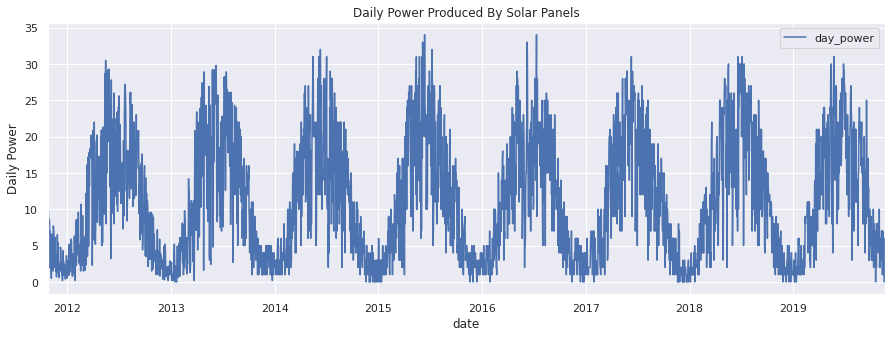

In [8]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.set()
power_index= power_info.reset_index()
power_index.plot(kind='line', x='date', y='day_power', figsize=(15,5))

plt.title('Daily Power Produced By Solar Panels')
plt.ylabel('Daily Power')
plt.show()

In [9]:
# weather 열을 제외한 모든 열 numeric 자료형으로 변경 

def clear_wind(obj):
    if isinstance(obj, str):
        if obj == 'No wind':
            obj = 0
        else:
            obj = obj.replace(' km/h', '')
    return obj
def trans_from_objects(weather):
    weather.drop(['Unnamed: 0', 'visibility'], axis =1, inplace=True)
    weather.barometer = weather.barometer.apply(lambda x: x.replace(' mbar', '') 
                                    if isinstance(x, str) else x).astype(float)
    
    weather.humidity = weather.humidity.apply(lambda x: x.replace('%', '') 
                                    if isinstance(x, str) else x).astype(float)
    weather.temp = weather.temp.apply(lambda x: x.replace('°C', '') 
                                    if isinstance(x, str) else x).astype(float)
    weather.wind = weather.wind.apply(clear_wind).astype(float)
    
    return weather

weather_tran = trans_from_objects(weather)
weather_tran.head()

,clock,temp,weather,wind,humidity,barometer,year,month,day
0,00:20,11.0,Mostly cloudy.,17.0,94.0,1011.0,2012,1,1
1,00:50,12.0,Mostly cloudy.,17.0,88.0,1011.0,2012,1,1
2,01:50,12.0,Overcast.,19.0,88.0,1011.0,2012,1,1
3,02:20,12.0,Partly cloudy.,17.0,88.0,1010.0,2012,1,1
4,02:50,12.0,Sprinkles. Mostly cloudy.,15.0,88.0,1010.0,2012,1,1


In [10]:
# date 형태의 열로 만들기 
def create_date(weather):    
    weather['date'] = weather.apply(lambda row:
                                    f'{row.year}-{row.month}-{row.day} {row.clock}', axis=1)
    weather.date = pd.to_datetime(weather.date)
    return weather.drop(['clock', 'year', 'month', 'day'], axis = 1)

weather_pretty = create_date(weather_tran)
weather_pretty.head()

,temp,weather,wind,humidity,barometer,date
0,11.0,Mostly cloudy.,17.0,94.0,1011.0,2012-01-01 00:20:00
1,12.0,Mostly cloudy.,17.0,88.0,1011.0,2012-01-01 00:50:00
2,12.0,Overcast.,19.0,88.0,1011.0,2012-01-01 01:50:00
3,12.0,Partly cloudy.,17.0,88.0,1010.0,2012-01-01 02:20:00
4,12.0,Sprinkles. Mostly cloudy.,15.0,88.0,1010.0,2012-01-01 02:50:00


In [11]:
# 각 변수 일별 평균으로 변경
import datetime 
def take_average_weather(weather):
    average_weather = pd.DataFrame(columns = ['temp', 'weather', 'wind', 'humidity', 'barometer',
                                              'date'])

    temp, wind, humidity, barometer, counter= [0]*5
    for i in range(len(weather)):
        if (weather.loc[i, 'date'].time() ==datetime.time(0, 20)) and (i!=0):
            average_weather = average_weather.append({
                'temp':temp/counter,
                'wind':wind/counter,
                'humidity':humidity/counter,
                'barometer':barometer/counter,
                'date':pd.to_datetime(weather.loc[i-1, 'date'].date()),
                'weather':weath
            }, ignore_index=True)
            temp, wind, humidity, barometer, counter= [0]*5
            
        # 일별 날씨 형태는 평균을 낼 수 없기 때문에, 가장 의미있는 15:20의 날씨 형태를 일일 날씨로 기입 (태양광에너지가 가장 많이 얻어지는 시기의 날씨)                   
        if (weather.loc[i, 'date'].time()==datetime.time(15,20)):
            weath = weather.loc[i, 'weather']
        counter += 1
        temp += weather.loc[i, 'temp']
        wind += weather.loc[i, 'wind']
        humidity += weather.loc[i, 'humidity']
        barometer += weather.loc[i, 'barometer']
        
    return average_weather
average_weather = take_average_weather(weather_pretty)

In [12]:
# 태양광 data와 weather data 병합
def merge_weatherANDpower():
    dataset = average_weather.merge(power_info, on=['date'])
    return dataset.set_index('date')
final_dataset = merge_weatherANDpower()
final_dataset.head()

,temp,weather,wind,humidity,barometer,day_power
date,,,,,,
2012-01-01,12.333333,Overcast.,21.333333,89.333333,1007.866667,0.8
2012-01-02,7.787234,Scattered clouds.,17.212766,81.425532,1009.170213,2.9
2012-01-03,8.208333,Light rain. Fog.,32.354167,78.229167,1007.916667,0.8
2012-01-04,7.354167,Broken clouds.,26.375000,71.041667,1012.687500,2.7
2012-01-05,8.292683,Rain showers. Broken clouds.,39.170732,77.804878,998.219512,1.6


In [13]:
final_dataset.weather.value_counts()  # 비와 눈 상태  // 구름 상태 -> 퍼지 숫자를 이용하여 구체적으로 numeric변환하면 좋을 듯

Passing clouds.                         959
Scattered clouds.                       519
Partly sunny.                           339
Sunny.                                  231
Broken clouds.                          207
Fog.                                     60
Sprinkles. Broken clouds.                51
Light rain. Broken clouds.               50
Light rain. Partly sunny.                43
Sprinkles. Scattered clouds.             24
Clear.                                   24
Drizzle. Partly sunny.                   21
Drizzle. Broken clouds.                  19
Drizzle. Fog.                            17
Ice fog.                                 14
Sprinkles. Partly sunny.                 13
Rain. Broken clouds.                      9
Light rain. Passing clouds.               8
Light rain. Scattered clouds.             8
Light rain. Fog.                          7
Sprinkles. Passing clouds.                7
Light snow. Broken clouds.                4
Haze.                           

In [14]:
final_dataset = final_dataset.reset_index()

# 2부분의 날씨 상태에서 첫번째 부분은 모두 삭제 ->  눈, 비가 중요한 것이 아니라 구름의 상태가 중요하기 때문

for i in range(len(final_dataset)):
    weather_list = final_dataset.loc[i, 'weather'].split('.')
    if len(weather_list) > 2:
        final_dataset.loc[i,'weather'] = weather_list[1].strip()
    elif len(weather_list) ==2:
        final_dataset.loc[i, 'weather'] = weather_list[0].strip()
final_dataset.head()

final_dataset.set_index('date', inplace=True)

In [15]:
final_dataset.weather.value_counts() # 구름 상태만 표현한 날씨 status

Passing clouds          974
Scattered clouds        557
Partly sunny            425
Broken clouds           346
Sunny                   231
Fog                      91
Clear                    27
Ice fog                  19
More clouds than sun      6
Mostly cloudy             5
Overcast                  4
Haze                      4
Low clouds                1
Cloudy                    1
Name: weather, dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


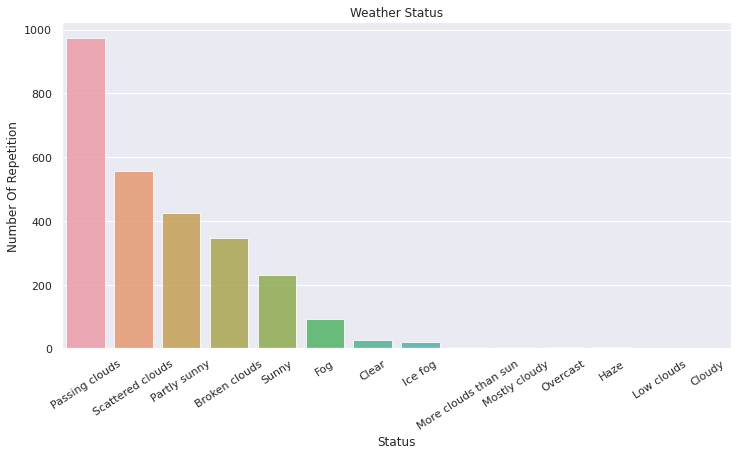

In [16]:
from matplotlib import pyplot as plt
final_dataset.weather.value_counts()
weather_counts = final_dataset.weather.value_counts()

plt.figure(figsize=(12,6))
sns.barplot(weather_counts.index, weather_counts.values, alpha=0.8)
plt.xticks(rotation=33)
plt.title('Weather Status')
plt.xlabel('Status')
plt.ylabel('Number Of Repetition')
plt.show()

In [18]:
data_1619 = final_dataset.iloc[1359:,:]

In [19]:
data_1619# 2016.01.01 ~ 2019.11.19까지만 사용

,temp,weather,wind,humidity,barometer,day_power
date,,,,,,
2016-01-01,5.822222,Sunny,10.777778,84.866667,1021.311111,2.0
2016-01-02,7.829787,Partly sunny,16.489362,81.340426,1007.553191,2.0
2016-01-03,7.234043,Scattered clouds,21.595745,80.255319,999.319149,2.0
2016-01-04,7.086957,Partly sunny,13.978261,83.021739,987.891304,1.0
2016-01-05,7.085106,Broken clouds,13.297872,81.978723,990.574468,1.0
...,...,...,...,...,...,...
2019-11-15,4.125000,Broken clouds,11.854167,85.375000,1000.750000,2.0
2019-11-16,3.755556,Broken clouds,6.622222,83.777778,1007.488889,4.0
2019-11-17,3.916667,Sunny,6.562500,86.895833,1010.791667,3.0


In [20]:
data_1619.isna().sum()

temp          0
weather       0
wind          2
humidity     17
barometer     2
day_power     0
dtype: int64

In [21]:
data_1619_re = data_1619.interpolate(method='cubic')  # 3차 스플라인 방법으로 결측치 보간

In [22]:
data_1619_re.isna().sum()

temp         0
weather      0
wind         0
humidity     0
barometer    0
day_power    0
dtype: int64

In [23]:
data_1619_re.to_csv('data_1619_re.csv', index=True)

In [24]:
from google.colab import files
files.download('data_1619_re.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>